# Рекомендательная система

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Для создания модели я выбрал набор данных от Amazon раздела Sowtware.

In [2]:
df = pd.read_csv('Software.csv', names=['item','user','rating','timestamp'])
df

,item,user,rating,timestamp
0,0077613252,A240ORQ2LF9LUI,4.0,1394496000
1,0077613252,A1YCCU0YRLS0FE,4.0,1393113600
2,0077613252,A1BJHRQDYVAY2J,1.0,1392595200
3,0077613252,APRDVZ6QBIQXT,3.0,1392595200
4,0077775473,A2JZTTBSLS1QXV,5.0,1381708800
...,...,...,...,...
459431,B01HF41TKI,AGEWYJ2NF5C2H,2.0,1480377600
459432,B01HF3G4BS,A3VCFV8WEQG9R5,1.0,1519862400
459433,B01HF3G4BS,A3DXGHJF6SOHNC,5.0,1512172800
459434,B01HJAMWOK,A1WOS4D7QA06DO,5.0,1536969600


## EDA

In [3]:
len(df['user'].unique()), len(df['item'].unique())

(375147, 21663)

В датасете 459 тыс. записей, а количество уникальных пользователей — 375 тыс. Получается, что большинство пользователей оставили только по одной оценке.

Построим гистограмму для количества оценок пользователей, а затем то же самое, но убрав всех пользователей с одной оценкой.

<AxesSubplot:>

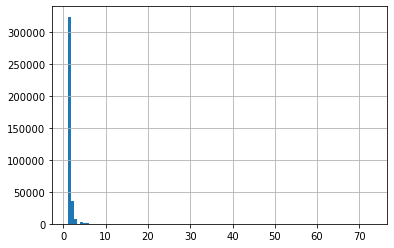

In [4]:
df['user'].value_counts().hist(bins=100)

<AxesSubplot:>

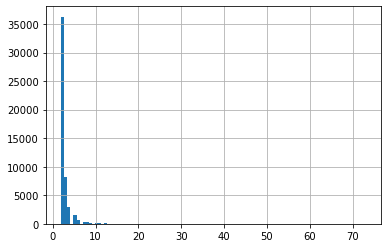

In [5]:
df[df.duplicated('user', keep=False)]['user'].value_counts().hist(bins=100)

Оперирование целым датасетом приводило к многочисленным ошибкам нехватки оперативной памяти при расчётах алгоритмов коллаборативной фильтрации. Поэтому решил сократить датасет, убрав всех пользователей с одной оценкой.

In [6]:
df = df[df.duplicated('user', keep=False)]
df

,item,user,rating,timestamp
13,0132147556,A1M4P30L5OACAI,3.0,1371427200
21,0321719816,A38NELQT98S4H8,4.0,1287532800
22,0321719816,A3QJU4FEN8PQSZ,4.0,1287360000
23,0321719816,ACJT8MUC0LRF0,5.0,1287187200
24,0321719816,A2RQ0AT4XZUIXL,5.0,1287014400
...,...,...,...,...
459411,B01HAP47PQ,AZ515FFZ7I2P7,3.0,1528934400
459415,B01HAP47PQ,A2WPL6Y08K6ZQH,4.0,1523836800
459419,B01HCPB7GQ,A3CHDLWLFJOXJP,1.0,1486944000
459433,B01HF3G4BS,A3DXGHJF6SOHNC,5.0,1512172800


Построим гистограмму для количества оценок товаров.

<AxesSubplot:>

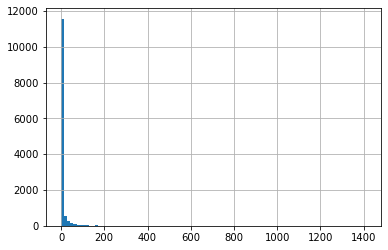

In [7]:
df['item'].value_counts().hist(bins=100)

In [9]:
df['item'].value_counts().median()

2.0

Медианное количество оценок у товаров — 2.

Извлечём в отдельный датасет названия товаров.

In [10]:
import os
import json
import gzip

metadata = []
with gzip.open('meta_Software.json.gz') as f:
    for l in f:
        metadata.append(json.loads(l.strip()))
    
len(metadata)

26790

In [11]:
df_meta = pd.DataFrame.from_dict(metadata)
df_meta.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,[],,[],,HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...,[],,HOLT. RINEHART AND WINSTON,[],"25,550 in Software (",[],Software,,</div>,.a-box-inner{background-color:#fff}#alohaBuyBo...,0030672120,[],[],NaN
1,[],,"[, <b>Latin rhythms that will get your kids si...",,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",[],,McGraw Hill,[],"15,792 in Software (",[],Software,,</div>,,0071480935,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,[],,[<b>Connect is the only integrated learning sy...,,Connect with LearnSmart Access Card for Microb...,[],,McGraw-Hill Science/Engineering/Math,[],"16,900 in Software (",[],Software,,</div>,,007329506X,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
3,[],,[],,LearnSmart Standalone Access Card for Prescott...,[],,McGraw-Hill Education,[],"12,986 in Software (",[],Software,,</div>,,0073513458,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,[],,[<i>Anatomy &amp; Physiology Revealed Cat</i> ...,,Anatomy &amp; Physiology Revealed Student Acce...,"[0323394612, 0323227937, 1118527488]",,McGraw-Hill Education,[],"14,861 in Software (",[],Software,,</div>,$4.83,0073525758,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [12]:
df_meta = df_meta[['title','brand','asin']]

Распределение оценок.

In [13]:
df.rating.value_counts()

5.0    64025
1.0    25247
4.0    23798
3.0    13129
2.0     9101
Name: rating, dtype: int64

In [14]:
df['rating'] = df['rating'].astype('int')

In [15]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

## Train-test split

In [16]:
df_train = df.copy()

Функция для разбиения.

In [17]:
def train_test_split(X, ratio=0.2, user_col='user', item_col='item',
                     rating_col='rating', time_col='timestamp'):
    # сортируем оценки по времени
    X.sort_values(by=[time_col], inplace=True)
    # список всех юзеров
    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []
    for userId in tqdm_notebook(userIds):
        curUser = X[X[user_col] == userId]
        # определяем позицию, по которой делим выборку и размещаем данные по массивам
        idx = int(curUser.shape[0] * (1 - ratio))
        if (idx == 0): idx = 1
        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])
    # cтекуем данные по каждому пользователю в общие массивы
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_train)

In [20]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((81464, 2), 81464, (53836, 2), 53836)

Хотя мы указывали отложить для тестирования 20% данных, в тестовом датасете оказалось их больше. Так произошло потому, что функция разбиения оперирует с целыми числами. Если, допустим, у пользователя две оценки, первая идёт в тренировочной датасет, вторая — в тестовый. Если у пользователя 5 оценок, 4 — в тренировочный, одна — в тестовый.

Сохраним средний рейтинг по всем данным.

In [24]:
mean_rating = y_train.mean()

## Построение моделей

### User-Based коллаборативная фильтрация

In [25]:
class UserBased(BaseEstimator):
    def fit(self, X, y, user_col='user', item_col='item'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку пользователя
        X['y'] -= X[user_col].apply(lambda x: self.mean_y_user[x])
        
        # создаём векторы для каждого пользователя из просмотренных фильмов
        # для неизвестных фильмов ставим оценку 0
        self.user_ratings = pd.pivot_table(X, values='y', index=user_col,
                                           columns=item_col, fill_value=0)
        
        # считаем попарную схожесть между юзерами
        self.user_sim = cosine_similarity(self.user_ratings)
        
        # также сделаем словарь - {значение user_col: index в user_ratings}
        self.user_pos = dict()
        for user in self.users:
            self.user_pos[user] = np.argwhere(self.user_ratings.index.values == user)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём средний рейтинг
        if not pr_item in self.items or not pr_user in self.users:
            return mean_rating
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = self.user_sim[self.user_pos[pr_user]].sum() - 1
        
        rating = self.mean_y_user[pr_user] + numerator / denominator
        
        # если значение рейтинга вышло за пределы 1..5, обрубаем его
        if (rating > 5):
            return 5
        elif (rating < 1):
            return 1
        
        return rating
    
    def predict(self, X, user_col='user', item_col='item'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

Тренируем модель и предсказываем рейтинги для теста.

In [26]:
ub = UserBased().fit(X_train, y_train)

In [27]:
p1 = ub.predict(X_test)

Некоторое количество предсказаний получилось NaN, заменим на средний рейтинг.

In [53]:
p1.fillna(mean_rating, inplace=True)

In [54]:
rmse(y_test,p1)

1.4562684006355042

Оценка качества RMSE для такого подхода — 1,456.

## Item-Based коллаборативная фильтрация

In [31]:
class ItemBased(BaseEstimator):
    def fit(self, X, y, user_col='user', item_col='item'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку предмета
        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])
        
        # создаём векторы для каждого фильма с оценками пользователя
        # если пользователь не поставил оценку, то ставим 0
        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)
        
        # считаем попарную схожесть между фильмами
        self.item_sim = cosine_similarity(self.item_ratings)
        
        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём средний рейтинг
        if not pr_item in self.items or not pr_user in self.users:
            return mean_rating
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = self.item_sim[self.item_pos[pr_item]].sum() - 1
        
        rating = self.mean_y_item[pr_item] + numerator / denominator
        
        # если значение рейтинга вышло за пределы 1..5, обрубаем его
        if (rating > 5):
            return 5
        elif (rating < 1):
            return 1
        
        return rating
    
    def predict(self, X, user_col='user', item_col='item'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

Тренируем модель и предсказываем рейтинги для теста.

In [32]:
ib = ItemBased().fit(X_train, y_train)

In [33]:
p2 = ib.predict(X_test)

Некоторое количество предсказаний получилось NaN, заменим на средний рейтинг.

In [34]:
p2.fillna(mean_rating, inplace=True)

In [35]:
rmse(y_test,p2)

1.7603914923827269

Оценка качества RMSE для такого подхода — 1,76.

### Библиотека Surprise

Для начала применим NormalPredictor.

In [36]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)

cross_validate(NormalPredictor(), data, cv=2)

{'test_rmse': array([1.99174069, 1.98876344]),
 'test_mae': array([1.58418814, 1.58032255]),
 'fit_time': (0.12566256523132324, 0.1515941619873047),
 'test_time': (0.5120785236358643, 0.5236353874206543)}

Показатель RMSE хуже, чем в самодельном алгоритме. Попробуем применить алгоритм SVD.

In [37]:
from surprise import SVD

cross_validate(SVD(), data, cv=5)

{'test_rmse': array([1.35279469, 1.34740071, 1.34907158, 1.34425127, 1.35090128]),
 'test_mae': array([1.11034444, 1.1094817 , 1.1056402 , 1.10537829, 1.10766394]),
 'fit_time': (8.347043514251709,
  8.024717569351196,
  8.901332378387451,
  8.109315395355225,
  8.496757507324219),
 'test_time': (0.23103928565979004,
  0.41489195823669434,
  0.2204113006591797,
  0.20943069458007812,
  0.21741986274719238)}

Этот метод гораздо лучше, RMSE снизилось до 1,34.

### Выводы

Для выбранного датасета построили рекомендательные системы сначала по самодельным алгоритмам коллаборативной фильтрации, затем применили библиотеку Surprise. Во втором случае при использовании алгоритма SVD качество рекомендаций оказалось лучше, при этом работает Surprise значительно быстрее.